<a href="https://colab.research.google.com/github/Saveh2010/time_series_project/blob/main/Week_2_XGBoost_kaggle_timeseries_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb

Read in the preprocessed data file from Week 1:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/favorita-grocery-sales-forecasting/train_processed_guayas_top3_week1.csv')

Let's look at the 10 top rows of the dataframe:

In [4]:
df_train.head(10)

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
0,24,105574,2013-01-02,18790.0,12.0,False,2013,1,2,2,NaN
1,24,105574,2013-01-03,59692.0,1.0,False,2013,1,3,3,NaN
2,24,105574,2013-01-04,99664.0,3.0,False,2013,1,4,4,NaN
3,24,105574,2013-01-05,140805.0,4.0,False,2013,1,5,5,NaN
4,24,105574,2013-01-06,182800.0,7.0,False,2013,1,6,6,NaN
5,24,105574,2013-01-07,223895.0,3.0,False,2013,1,7,0,NaN
6,24,105574,2013-01-08,263107.0,3.0,False,2013,1,8,1,4.714286
7,24,105574,2013-01-09,302232.0,7.0,False,2013,1,9,2,4.000000
8,24,105574,2013-01-10,341031.0,3.0,False,2013,1,10,3,4.285714
9,24,105574,2013-01-11,379570.0,6.0,False,2013,1,11,4,4.714286


In [5]:
df_train.tail()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
35069351,51,2123791,2017-08-11,NaN,0.0,NaN,2017,8,11,4,0.000000
35069352,51,2123791,2017-08-12,NaN,0.0,NaN,2017,8,12,5,0.000000
35069353,51,2123791,2017-08-13,NaN,0.0,NaN,2017,8,13,6,0.000000
35069354,51,2123791,2017-08-14,NaN,0.0,NaN,2017,8,14,0,0.000000
35069355,51,2123791,2017-08-15,125491523.0,1.0,False,2017,8,15,1,0.142857


Selecting only the rows with the dates that are before April 1st 2014:

In [6]:
max_date = "2014-04-01"
df_train = df_train[(df_train["date"] < max_date)]
df_train.shape

(9437752, 11)

Encoding the "onpromotion" column and changing the datetype to int:

In [7]:
df_train.loc[df_train["onpromotion"] != False, "onpromotion"] = 1
df_train.loc[df_train["onpromotion"] == False, "onpromotion"] = 0
df_train['onpromotion'] = df_train['onpromotion'].astype(int)
df_train["onpromotion"].unique()

array([0, 1])

In [8]:
promotion_counts = df_train['onpromotion'].value_counts()

print("Counts of True and False in 'onpromotion' column:")
promotion_counts

Counts of True and False in 'onpromotion' column:


,count
onpromotion,
1,6690477
0,2747275


Generating new features:

In [10]:
# Ensure the 'date' column is in datetime format
df_train['date'] = pd.to_datetime(df_train['date'])

# Date / Time Features
df_train['is_weekend'] = 0
df_train.loc[df_train['day_of_week'] >= 5, 'is_weekend'] = 1
df_train['week_of_year'] = df_train['date'].dt.isocalendar().week.astype(int)
df_train['season'] = (df_train['month'] % 12 // 3 + 1)         # Winter=1, Spring=2, Summer=3, Fall=4
df_train['is_month_end'] = df_train['date'].dt.is_month_end.astype(int)

# Lag Features
df_train['lag_1'] = df_train['unit_sales'].shift(1)
df_train["lag_7"] = df_train["unit_sales"].shift(7)
df_train['lag_28'] = df_train['unit_sales'].shift(28)

# Rolling Window Features
df_train['rolling_mean_7'] = df_train['unit_sales'].shift(1).rolling(window=7).mean()
df_train['rolling_std_7'] = df_train['unit_sales'].shift(1).rolling(window=7).std()

# Trend / Change Features
df_train['diff_1'] = df_train['unit_sales'] - df_train['lag_1']             # Daily change
df_train['ratio_7'] = df_train['unit_sales'] / (df_train['lag_7'] + 1e-5)   # Weekly change ratio

# Promotion History
df_train['on_promo_last_7d'] = df_train['onpromotion'].shift(1).rolling(window=7).sum()

# Domain-Specific Features
df_train['store_avg_sales'] = df_train.groupby('store_nbr')['unit_sales'].transform('mean')
df_train['item_avg_sales'] = df_train.groupby('item_nbr')['unit_sales'].transform('mean')
df_train['store_item_avg'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform('mean')

In [16]:
df_train.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,...,lag_7,lag_28,rolling_mean_7,rolling_std_7,diff_1,ratio_7,on_promo_last_7d,store_avg_sales,item_avg_sales,store_item_avg
28,24,105574,2013-01-30,1149321.0,1.0,0,2013,1,30,2,...,3.0,12.0,3.714286,2.429972,-3.0,0.333332,1.0,3.276405,9.626652,7.26652
29,24,105574,2013-01-31,1189067.0,1.0,0,2013,1,31,3,...,0.0,1.0,3.428571,2.636737,0.0,100000.000000,1.0,3.276405,9.626652,7.26652
30,24,105574,2013-02-01,1229986.0,6.0,0,2013,2,1,4,...,3.0,3.0,3.571429,2.439750,5.0,1.999993,0.0,3.276405,9.626652,7.26652
31,24,105574,2013-02-02,1273695.0,7.0,0,2013,2,2,5,...,5.0,4.0,4.000000,2.581989,1.0,1.399997,0.0,3.276405,9.626652,7.26652
32,24,105574,2013-02-03,1317962.0,9.0,0,2013,2,3,6,...,8.0,7.0,4.285714,2.811541,2.0,1.124999,0.0,3.276405,9.626652,7.26652


In [17]:
#  Drop rows with NaN values from lag/rolling features
df_train = df_train.dropna()

In [18]:
df_train.dtypes

,0
store_nbr,int64
item_nbr,int64
date,datetime64[ns]
id,float64
unit_sales,float64
onpromotion,int64
year,int64
month,int64
day,int64
day_of_week,int64


In [19]:
df_train.head().reset_index(drop=True)

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,...,lag_7,lag_28,rolling_mean_7,rolling_std_7,diff_1,ratio_7,on_promo_last_7d,store_avg_sales,item_avg_sales,store_item_avg
0,24,105574,2013-01-30,1149321.0,1.0,0,2013,1,30,2,...,3.0,12.0,3.714286,2.429972,-3.0,0.333332,1.0,3.276405,9.626652,7.26652
1,24,105574,2013-01-31,1189067.0,1.0,0,2013,1,31,3,...,0.0,1.0,3.428571,2.636737,0.0,100000.000000,1.0,3.276405,9.626652,7.26652
2,24,105574,2013-02-01,1229986.0,6.0,0,2013,2,1,4,...,3.0,3.0,3.571429,2.439750,5.0,1.999993,0.0,3.276405,9.626652,7.26652
3,24,105574,2013-02-02,1273695.0,7.0,0,2013,2,2,5,...,5.0,4.0,4.000000,2.581989,1.0,1.399997,0.0,3.276405,9.626652,7.26652
4,24,105574,2013-02-03,1317962.0,9.0,0,2013,2,3,6,...,8.0,7.0,4.285714,2.811541,2.0,1.124999,0.0,3.276405,9.626652,7.26652


Now, as the data is filtered, let`s split it into 2 portions: testing and training ones!

In [20]:
split_date = '2014-01-01'
train = df_train[df_train['date'] < split_date]
test = df_train[df_train['date'] >= split_date]

In [21]:
X_train = train.drop(['date', 'id', 'unit_sales'], axis=1)
y_train = train['unit_sales']

X_test = test.drop(['date', 'id', 'unit_sales'], axis=1)
y_test = test['unit_sales']

Training the Model:

In [22]:
xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    enable_categorical=True
)

xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Prediction:

In [24]:
y_pred = xgboost_model.predict(X_test)

Visualizing the predicted vs acutal data:

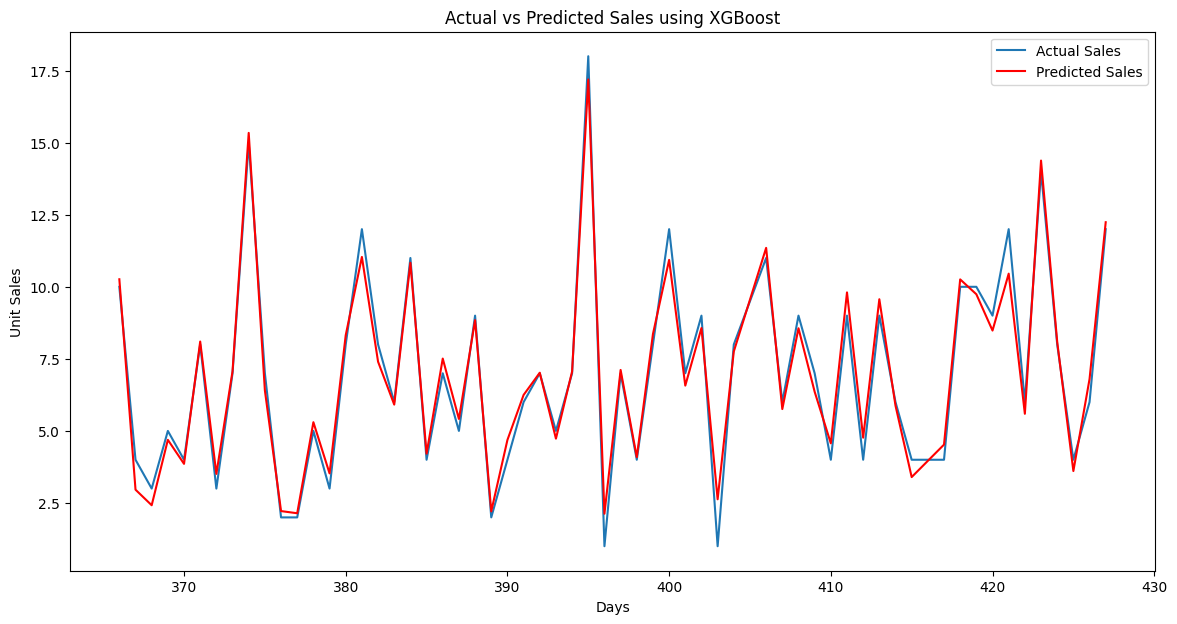

In [44]:
i = 60 # number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label="Actual Sales")
plt.plot(y_test.index[:i], y_pred[:i], label="Predicted Sales", color='red')
plt.xlabel("Days")
plt.ylabel("Unit Sales")
plt.title("Actual vs Predicted Sales using XGBoost")
plt.legend()
plt.show()

Model Evaluation:

In [46]:
from sklearn.metrics import mean_squared_error

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 10.91549806257663
